## Using continuous GA solver to find parameters of a system of ODEs

Many real-world phenomena can be easily described by systems of differential equations, such as for example, how one variable changes with respect to time. Solving these systems, analytically or numerically, allows us then to know the value of our variables of interest in a given time point.

Take for example the following chemical reactions, where two molecules of A form one molecule of B which then forms one molecule of C:

$2A \xrightarrow{k_1} B \xrightarrow{k_2} C $

The law of mass action tells us that the rate of change of each molecule with respect to time can be written as:

$$\frac{dA}{dt} = -k_1A^2$$<br>
$$\frac{dB}{dt} = k_1A^2 - k_2B$$<br>
$$\frac{dC}{dt} = k_2B$$<br>


(This works for elementary reactions. For general reactions we wouldnt know the exponents of A,B or C.)<br>
If we know the values of k1 and k2, we can know the behaviour of the system at different time points for any given initial conditions.

If we let:

$$k_1 = 0.01$$<br>
$$k_2 = 0.1$$<br>
$$A_0 = 100$$<br>
$$B_0 = C_0 = 0$$<br>

We can use scipys ODE solver (or in this simple case, solve it by hand) to find the amount of A,B and C w.r.t time

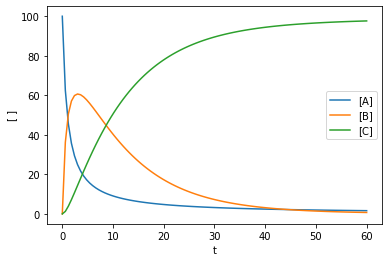

In [6]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def diffeq(ABC,t,k1,k2):
    
    A,B,C = ABC
    dA = -k1*A**2
    dB = k1*A**2 - k2*B
    dC = k2*B
    return [dA,dB,dC]

ABC0 = [100,0,0]
t = np.linspace(0,60,101)

true_k1 = 0.01
true_k2 = 0.1
observed = odeint(diffeq, ABC0, t, args=(true_k1, true_k2))

labels = ["[A]","[B]","[C]"]
for i in range(3):
    
    _ = plt.plot(t,observed[:,i],label = labels[i])

plt.xlabel("t")
plt.ylabel("[ ]")
_ = plt.legend()

### What if we dont know k1 or k2?

If we dont know k1 or k2, we need to get some data and estimate them. One problem however: **for most situations, the data collected will be of your variables w.r.t to time, but your ODES represent the rate of change w.r.t to your variables!**

That is, we will get data similar to the one we just simulated: A, B and C w.r.t time.

How to estimate k1 or k2? If the system of ODEs can be solved analytically, we can find the expression of A,B and C w.r.t time and use non linear least squares to solve for k1 and k2. We could actually do this for this problem. We will rarely be this lucky however, so lets pretend we dont have that expression.

It turns out that parameter estimation of ODEs is really tricky and an active area of research. Genetic algorithms have proven to be quite good at this task. 

The idea is simple, each individual will have a k1 and k2 value (here we pretend we know the inital conditions). We solve the system of ODEs for each individual, and we measure the error of each individual w.r.t the collected data. We find a suitable fitness function (remember we want to _minimize_ this error but in GA we _maximize_ this fitness) and let the GA do its magic!

For the fitness function first we calculate the squared norm of the difference between the predicted concentrations and the observed concentrations. The fitness is 1 over that value. We know from chemistry that k1 and k2 cannot be negative. We do need some upper bounds, lets say, 20.

In [7]:
from pyGeneticAlgorithm.continuous_solver import continuousGeneticSolver as cGS

In [9]:
def fitness(K):
    k1,k2 = K
    ABC0 = [100,0,0]
    sol = odeint(diffeq, ABC0, t, args=(k1, k2))
    return (1/np.linalg.norm(sol - observed))

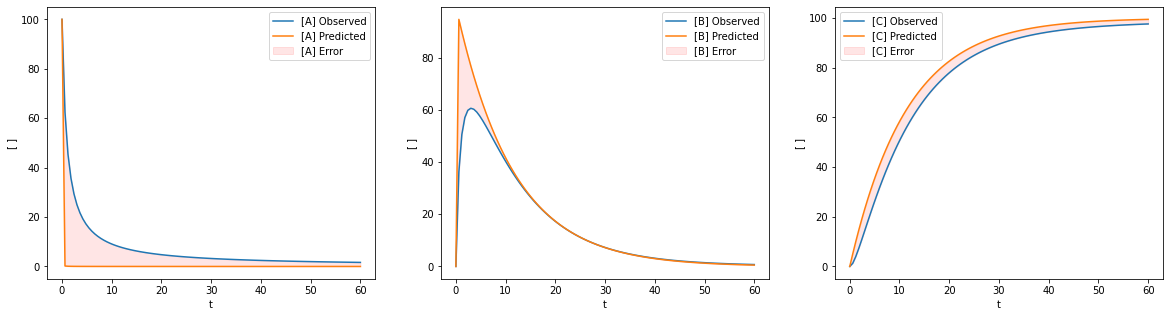

Total error of the best individual this generation: 146.63273380197174


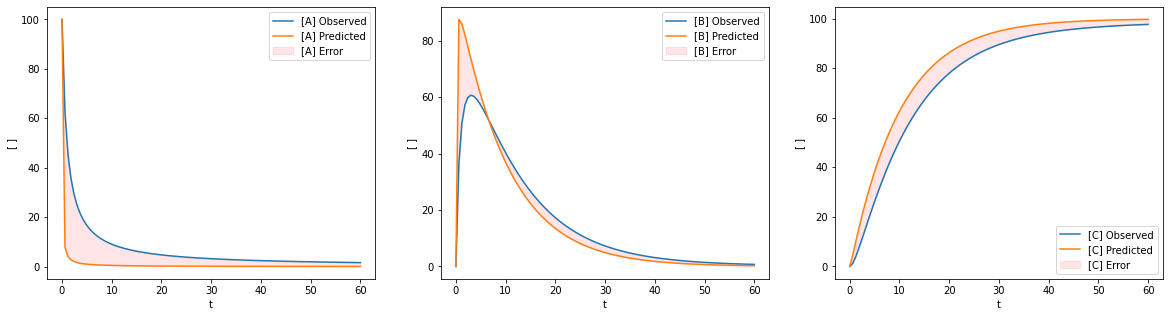

Total error of the best individual this generation: 145.0831174695388


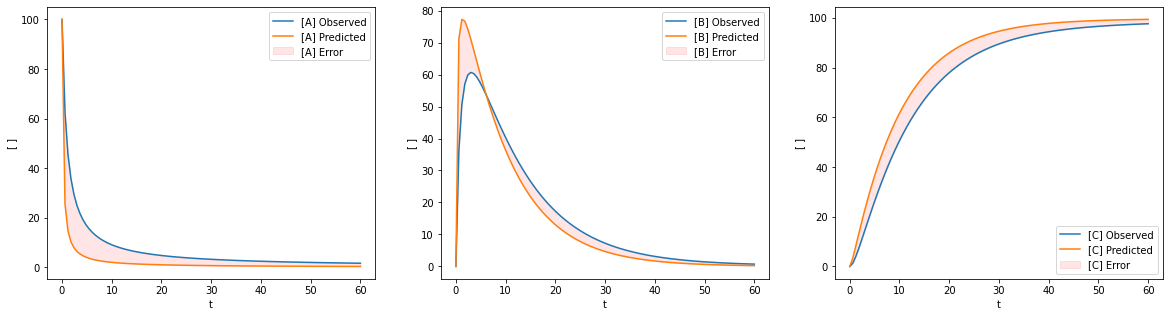

Total error of the best individual this generation: 116.3829738454177


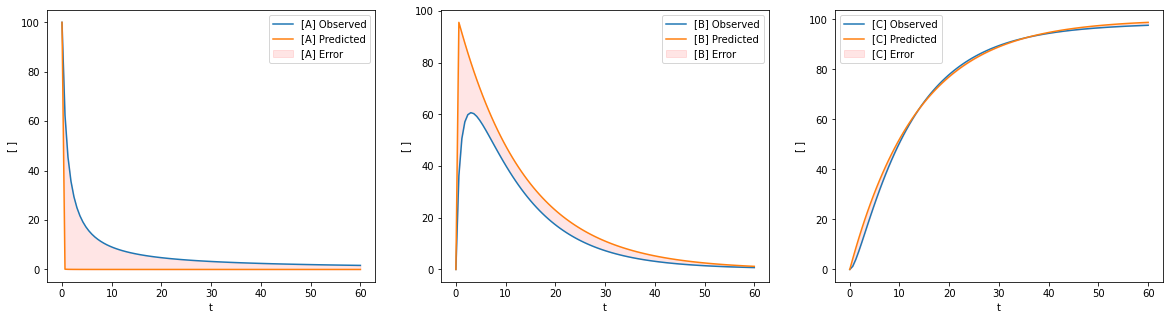

Total error of the best individual this generation: 149.27599280330884


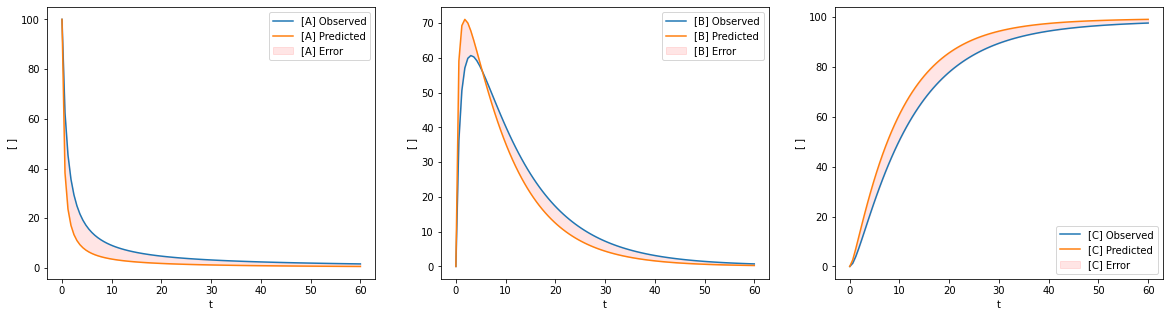

Total error of the best individual this generation: 94.73805797026239


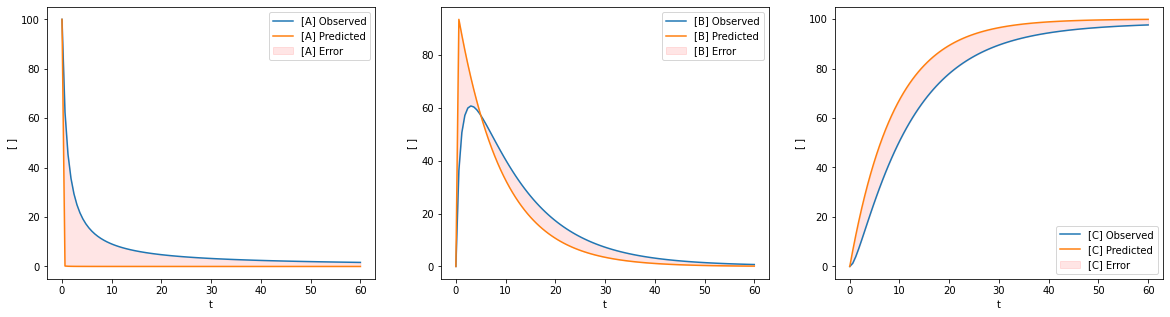

Total error of the best individual this generation: 171.02736698287765


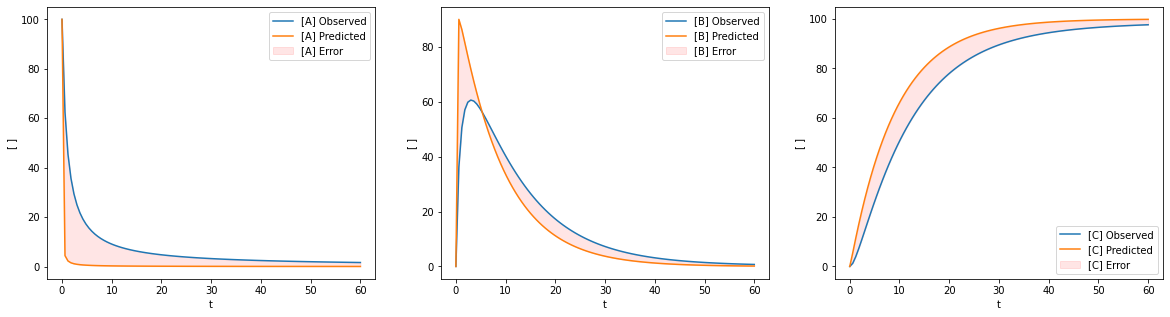

Total error of the best individual this generation: 161.56938750800091


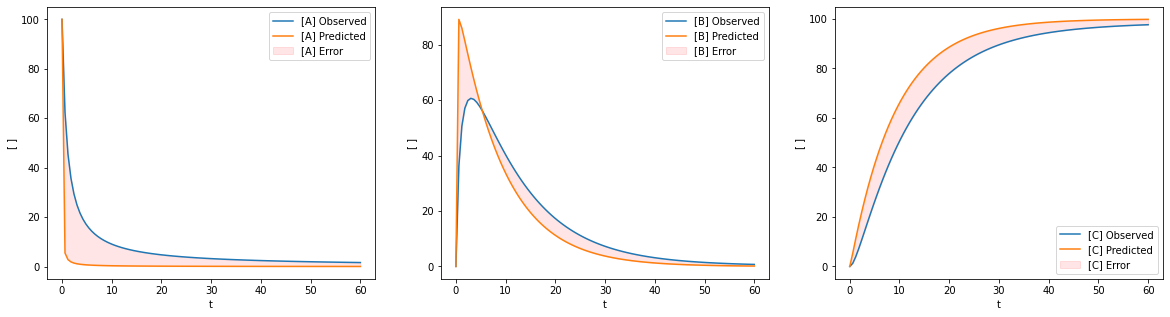

Total error of the best individual this generation: 159.67972683796904


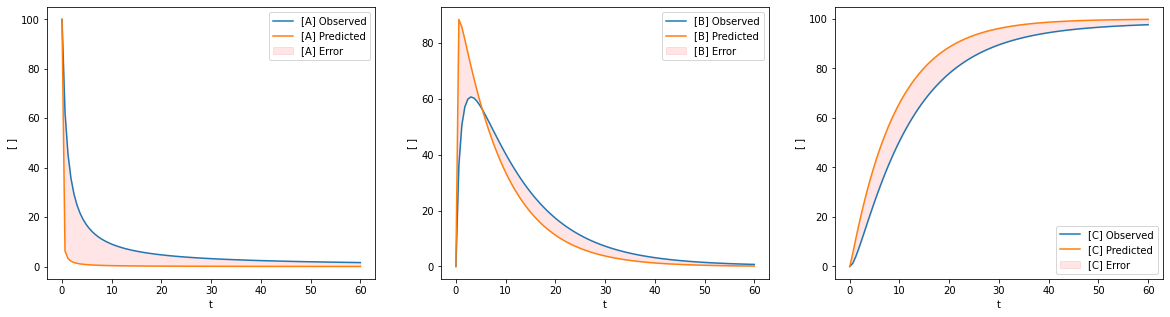

Total error of the best individual this generation: 158.40937601722058


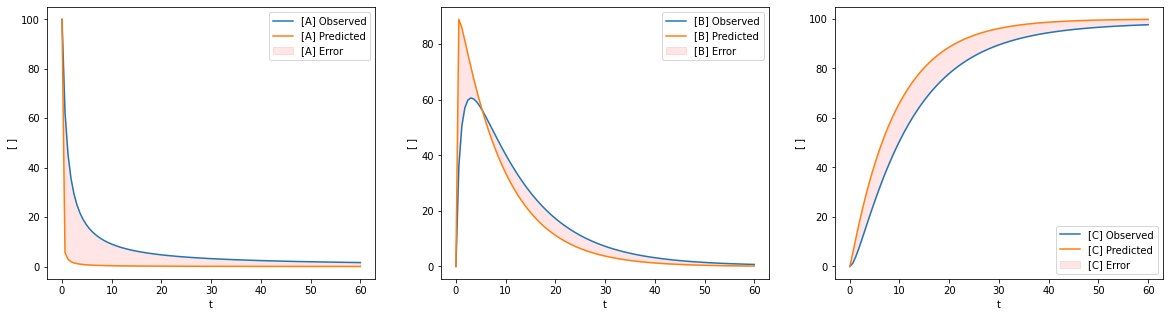

Total error of the best individual this generation: 159.38541596541688


In [11]:
cgs = cGS(0.01,fitness,[0,0],[20,20],1000)
min_err = np.inf
best_guess = None

for i in range(10):
    
    res = cgs.solve(10, verbose = False)
    calc = odeint(diffeq, ABC0, t, args=(res[0], res[1]))
    err = np.linalg.norm(observed - calc)
    if err < min_err:
        
        best_guess = res
        min_err = err
        
    gs = gridspec.GridSpec(1, 3)
    fig = plt.figure(figsize=(20,5))
    for i in range(3):

        ax = fig.add_subplot(gs[0, i])
        _ = ax.plot(t, observed[:,i], label = f"{labels[i]} Observed")    
        _ = ax.plot(t, calc[:,i], label = f"{labels[i]} Predicted")
        _ = ax.set_xlabel("t")
        _ = ax.set_ylabel("[ ]")
        _ = ax.fill_between(t, observed[:,i], calc[:,i], color='red', alpha=0.1, label = f"{labels[i]} Error")
        _ = ax.legend()
    plt.show()
    print(f"Total error of the best individual this generation: {err}")